In [4]:
from pathlib import Path
import sys

ROOT = Path.cwd()
if (ROOT / "src").exists() is False and (ROOT.parent / "src").exists():
    ROOT = ROOT.parent

sys.path.insert(0, str(ROOT))

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from sklearn.linear_model import LinearRegression
from src.viz import *

Data part

In [6]:
plot_params = {
    "figsize": (11, 4),
    "grid": True,
    "linewidth": 2,
}

store_sales = pd.read_csv(
    ROOT / 'Data/train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)

holidays_events = pd.read_csv(
    ROOT / "Data/holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

In [7]:
X = average_sales.to_frame()
X["week"] = X.index.week
X["day"] = X.index.dayofweek
X

,sales,week,day
date,,,
2017-01-01,6.780303,52,6
2017-01-02,786.928406,1,0
2017-01-03,619.740234,1,1
2017-01-04,555.607971,1,2
2017-01-05,436.375397,1,3
...,...,...,...
2017-08-11,463.733856,32,4
2017-08-12,444.798309,32,5
2017-08-13,485.768616,32,6


<Axes: title={'center': 'Seasonal Plot (week/day)'}, xlabel='day', ylabel='sales'>

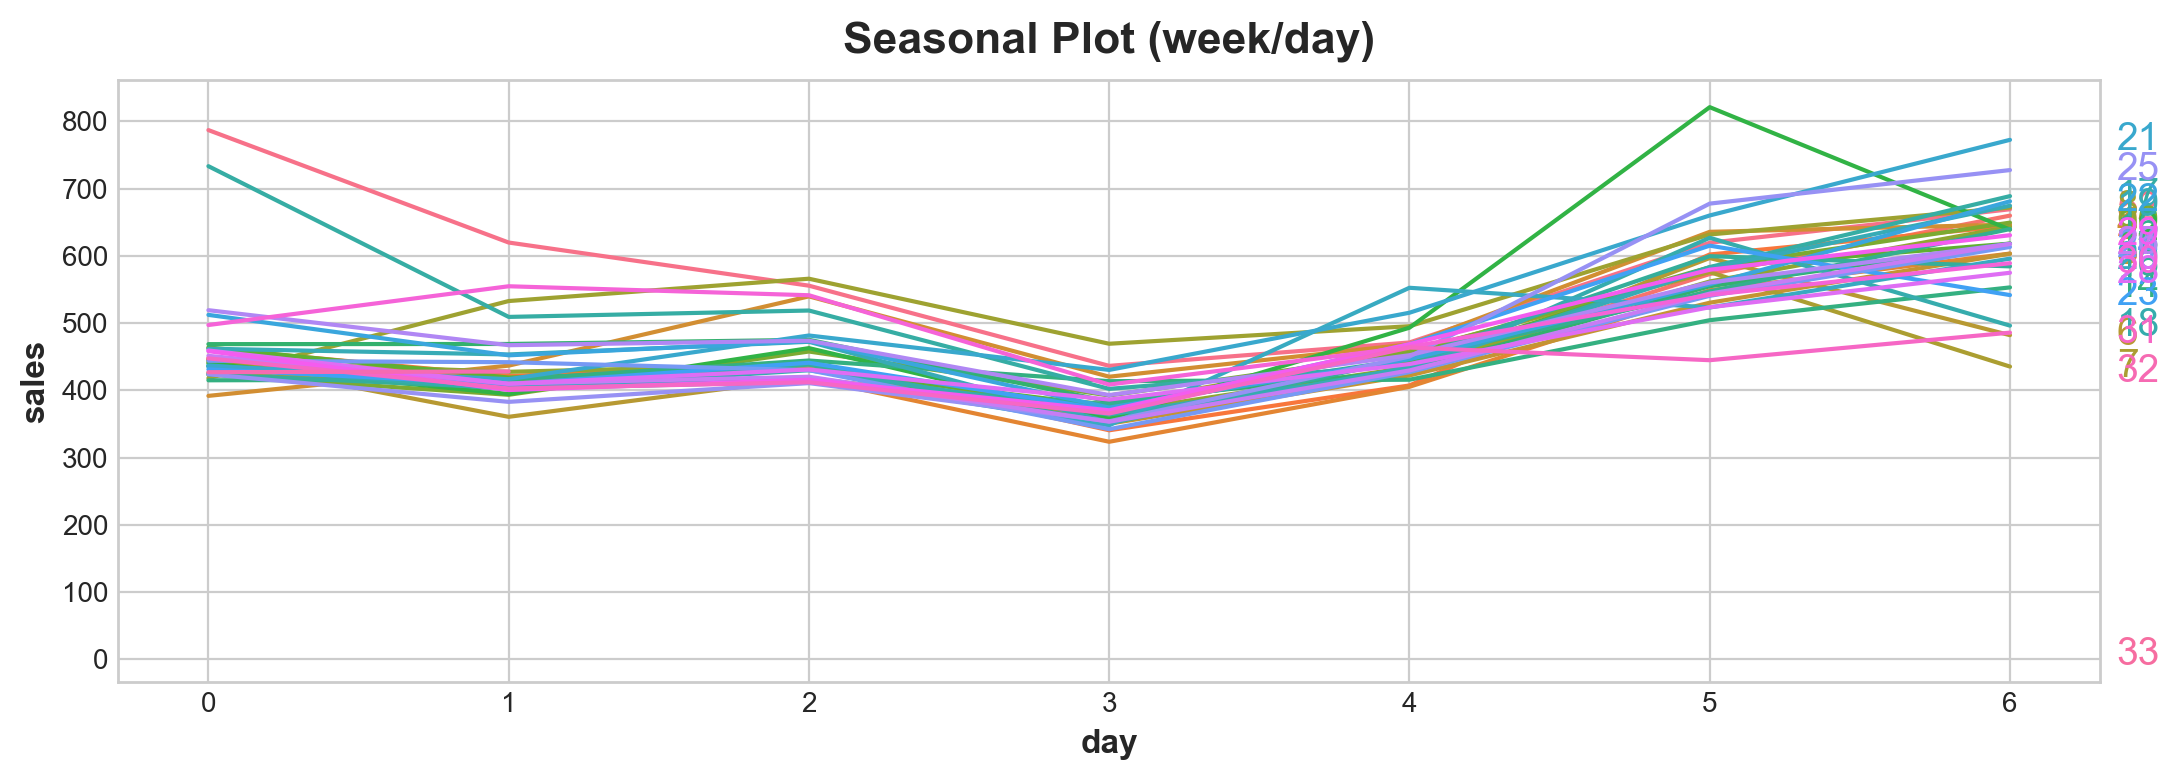

In [8]:
seasonal_plot(X,y='sales',period='week',freq='day')

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

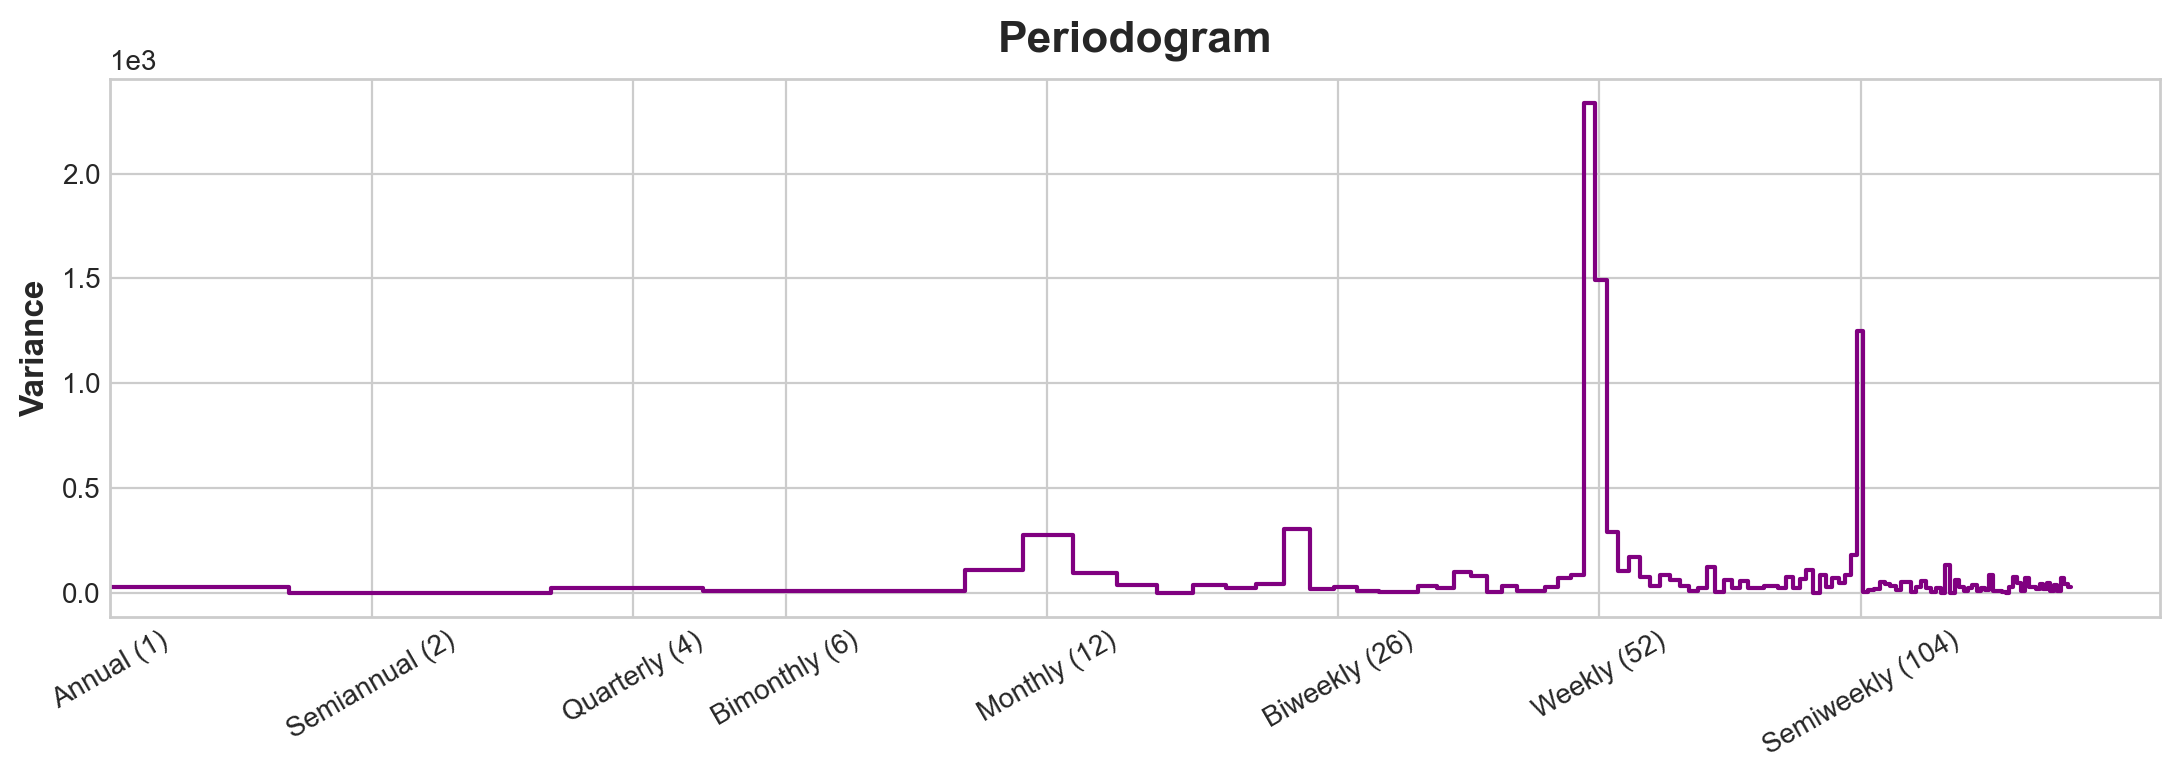

In [9]:
plot_periodogram(average_sales)

We could say that there is a weekly seasonality as well as monthly and biweekly.

In [10]:
y = average_sales.copy()

fourier = CalendarFourier(freq = 'M', order=4)

dp = DeterministicProcess(
    index = y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)

X = dp.in_sample()

X.head(3)

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=ME)","cos(1,freq=ME)","sin(2,freq=ME)","cos(2,freq=ME)","sin(3,freq=ME)","cos(3,freq=ME)","sin(4,freq=ME)","cos(4,freq=ME)"
date,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2017-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,0.394356,0.918958,0.571268,0.820763,0.724793,0.688967
2017-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,0.724793,0.688967,0.937752,0.347305,0.998717,-0.050649


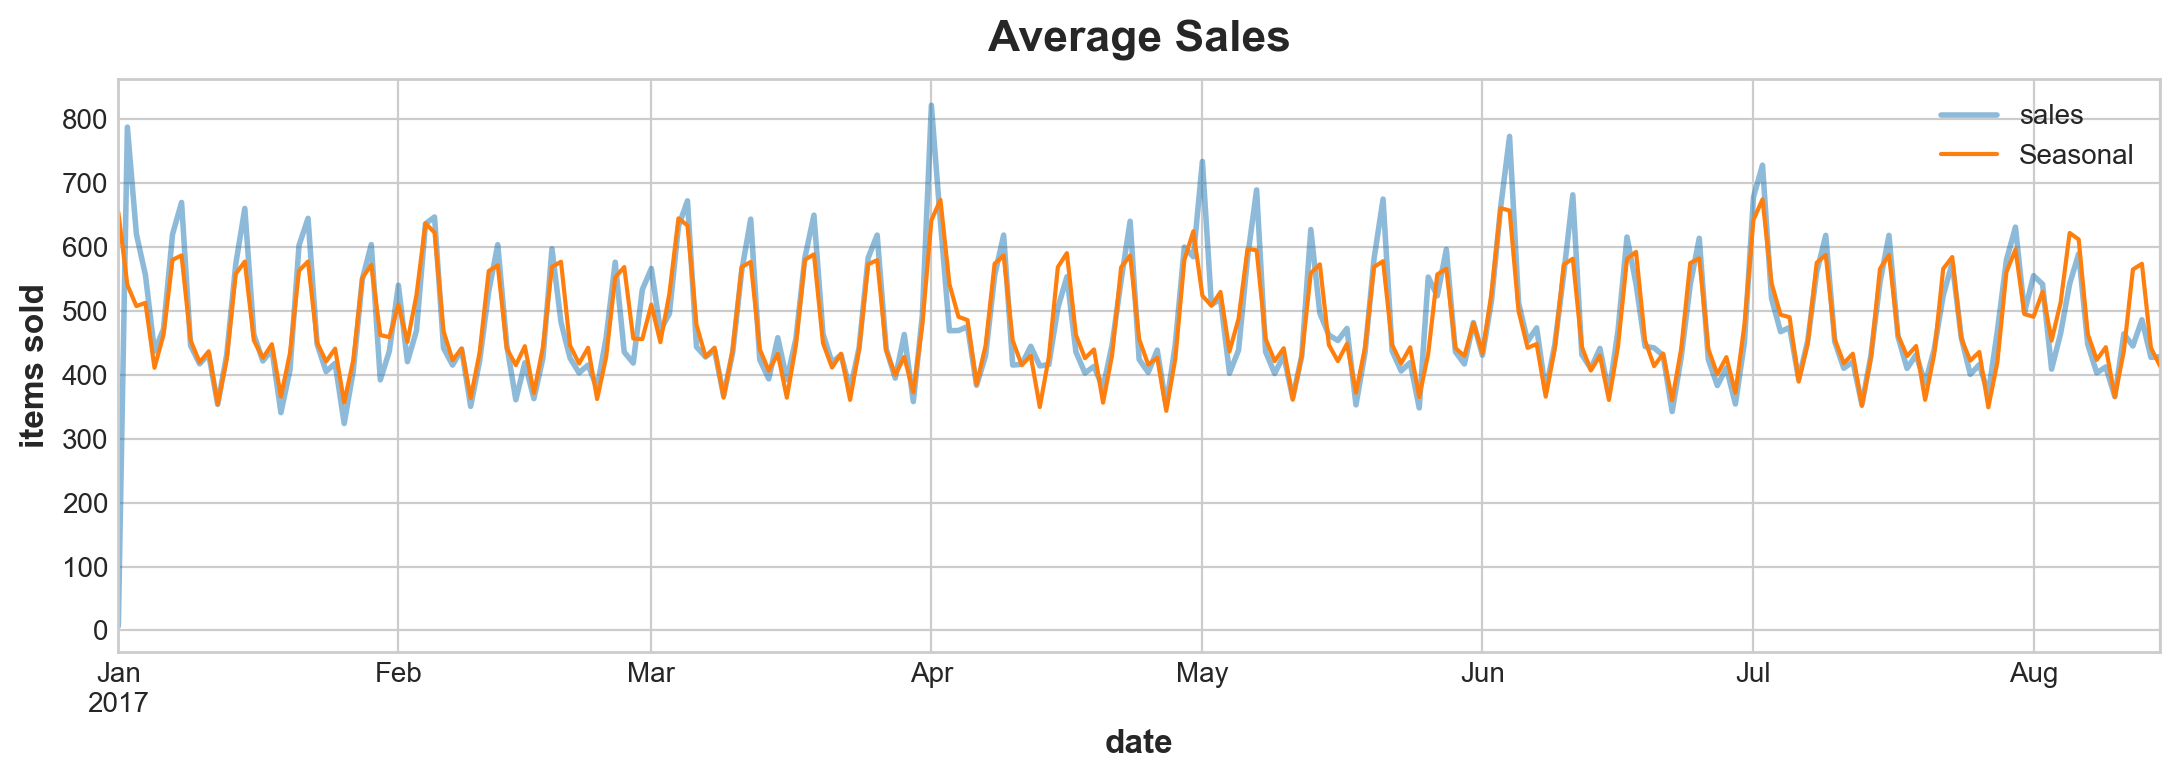

In [11]:
model = LinearRegression(fit_intercept=False)
model.fit(X,y)

y_pred = pd.Series(model.predict(X), index = X.index, name = 'Fitted')
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend()


# Deseason a time series

Text(0.5, 1.0, 'Deseasonalized')

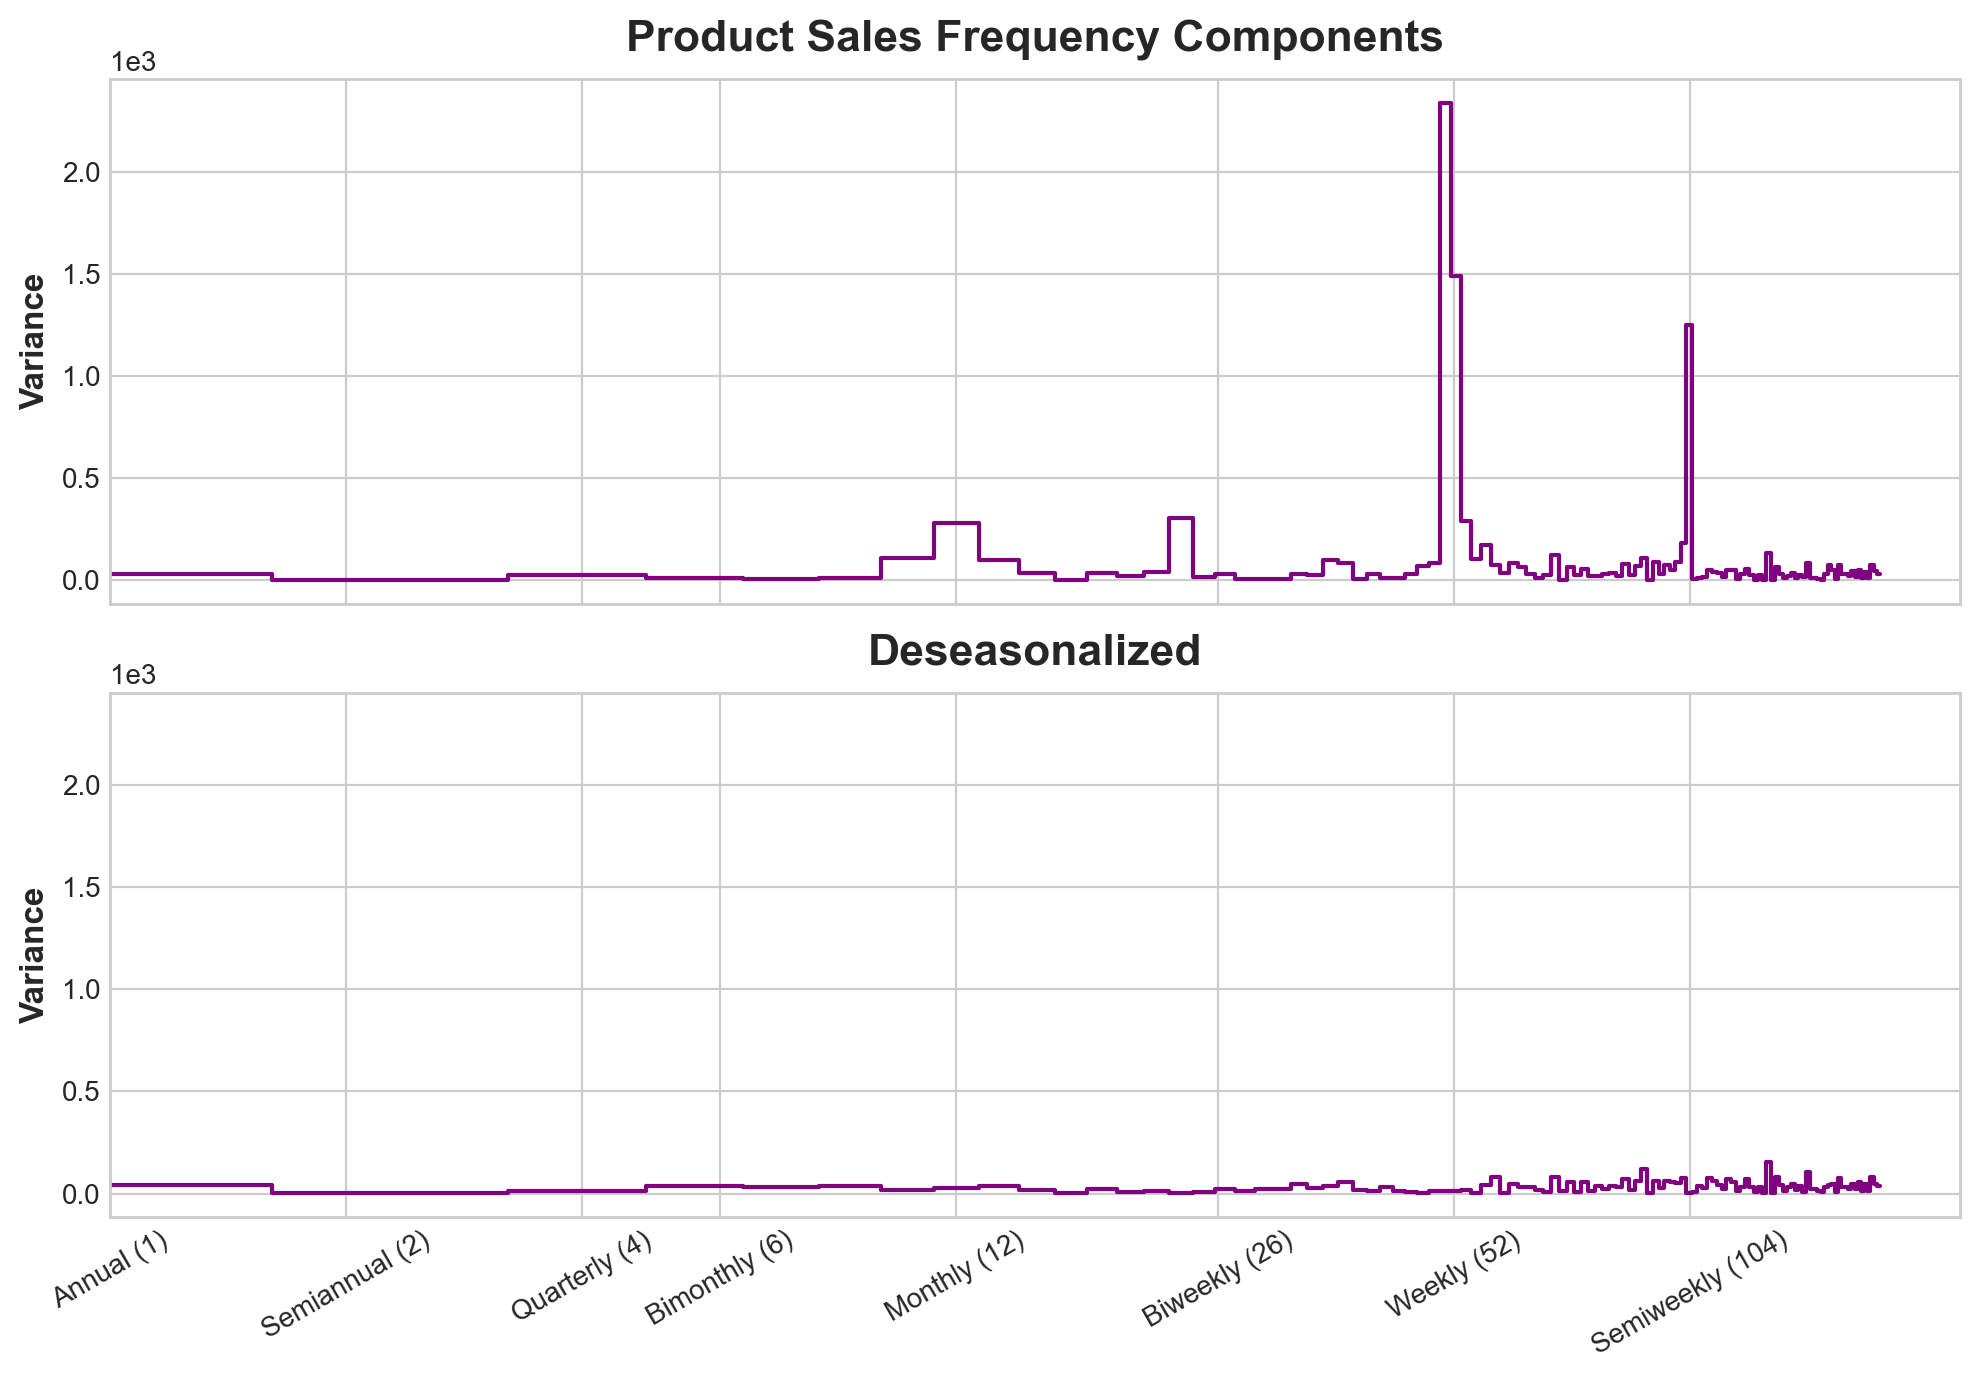

In [12]:
y_deseason = y - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_deseason, ax=ax2)
ax2.set_title("Deseasonalized")

In [13]:
holidays_events

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [14]:
holidays = (
    holidays_events
    .assign(date=pd.to_datetime(holidays_events["date"]))
    .set_index("date")
    .to_period("D")
    .loc["2017":"2017-08-15", ["description"]]
)

display(holidays)

,description
date,
2017-01-01,Primer dia del ano
2017-01-02,Traslado Primer dia del ano
2017-02-27,Carnaval
2017-02-28,Carnaval
2017-03-02,Fundacion de Manta
2017-04-01,Provincializacion de Cotopaxi
2017-04-12,Fundacion de Cuenca
2017-04-13,Fundacion de Cuenca
2017-04-14,Cantonizacion de Libertad


Text(0.5, 1.0, 'National and Regional Holidays')

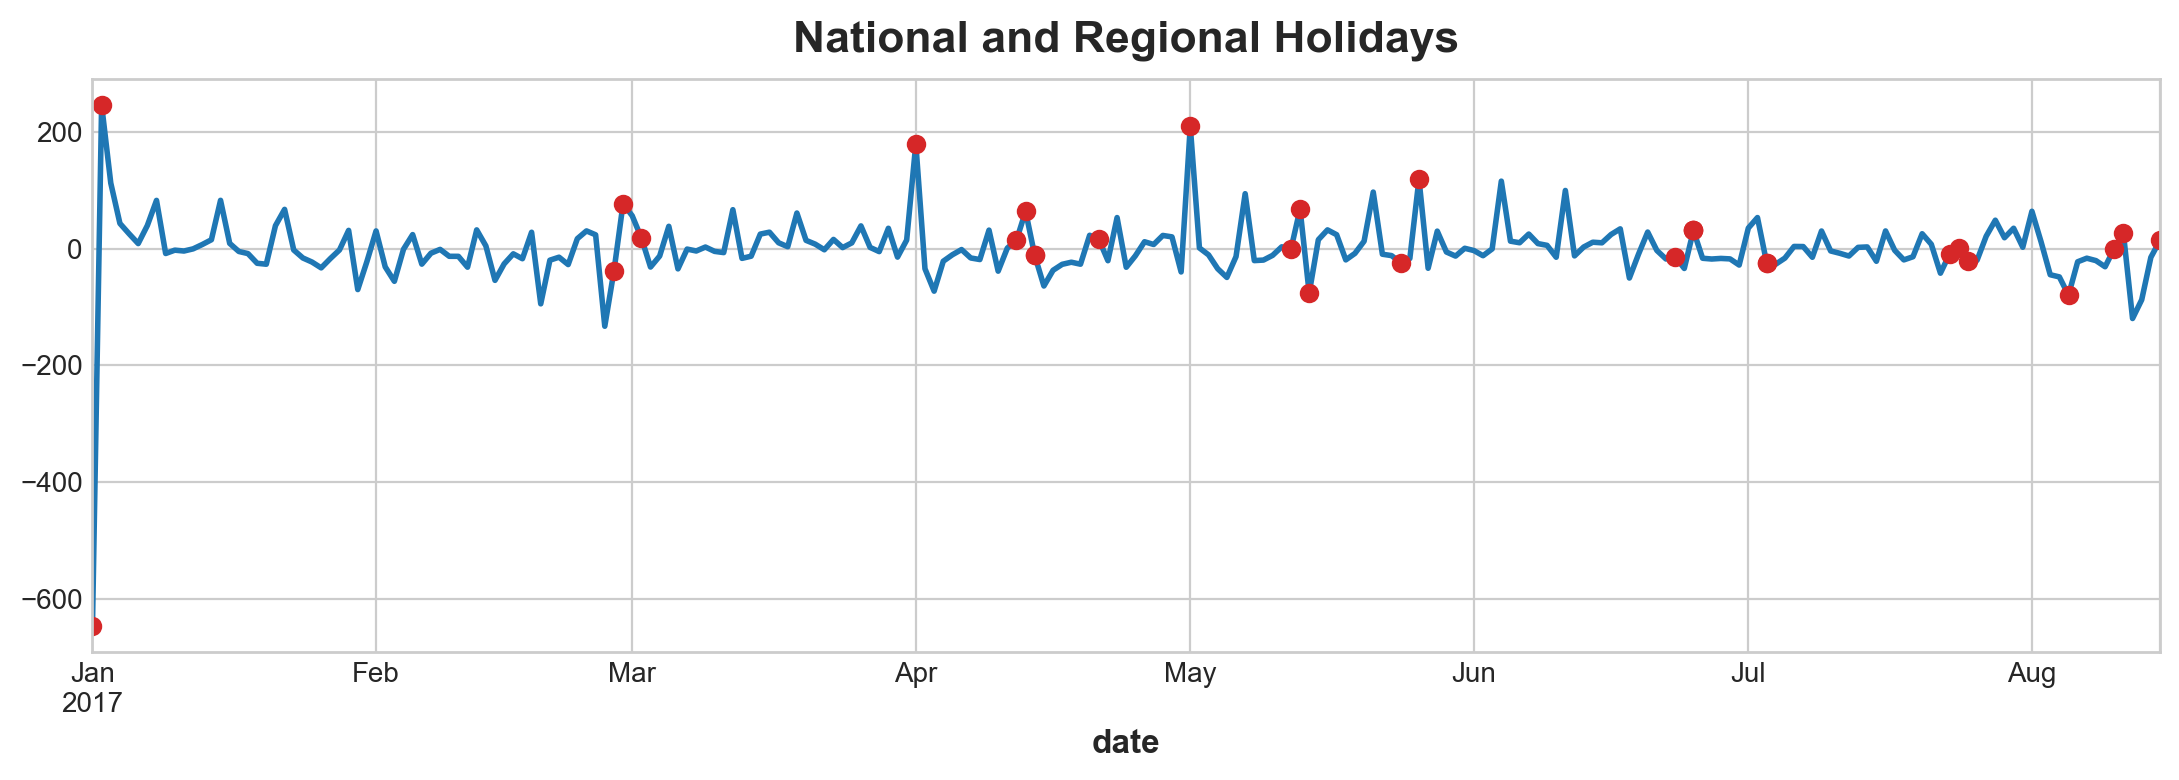

In [15]:
ax = y_deseason.plot(**plot_params)
plt.plot_date(holidays.index, y_deseason[holidays.index], color='C3')
ax.set_title('National and Regional Holidays')

Ok, we see that there is a pattern with the fact that weather or not the date is a holiday or not (more extreme value)

In [16]:
X_holidays = (
    pd.get_dummies(holidays)
    .groupby(level=0)
    .max()
    )

X2 = X.join(X_holidays, on = 'date').fillna(0.0)
X2.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=ME)","cos(1,freq=ME)",...,description_Terremoto Manabi+7,description_Terremoto Manabi+8,description_Terremoto Manabi+9,description_Traslado Batalla de Pichincha,description_Traslado Fundacion de Guayaquil,description_Traslado Fundacion de Quito,description_Traslado Independencia de Guayaquil,description_Traslado Primer Grito de Independencia,description_Traslado Primer dia del ano,description_Viernes Santo
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,...,False,False,False,False,False,False,False,False,False,False
2017-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,...,False,False,False,False,False,False,False,False,True,False
2017-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


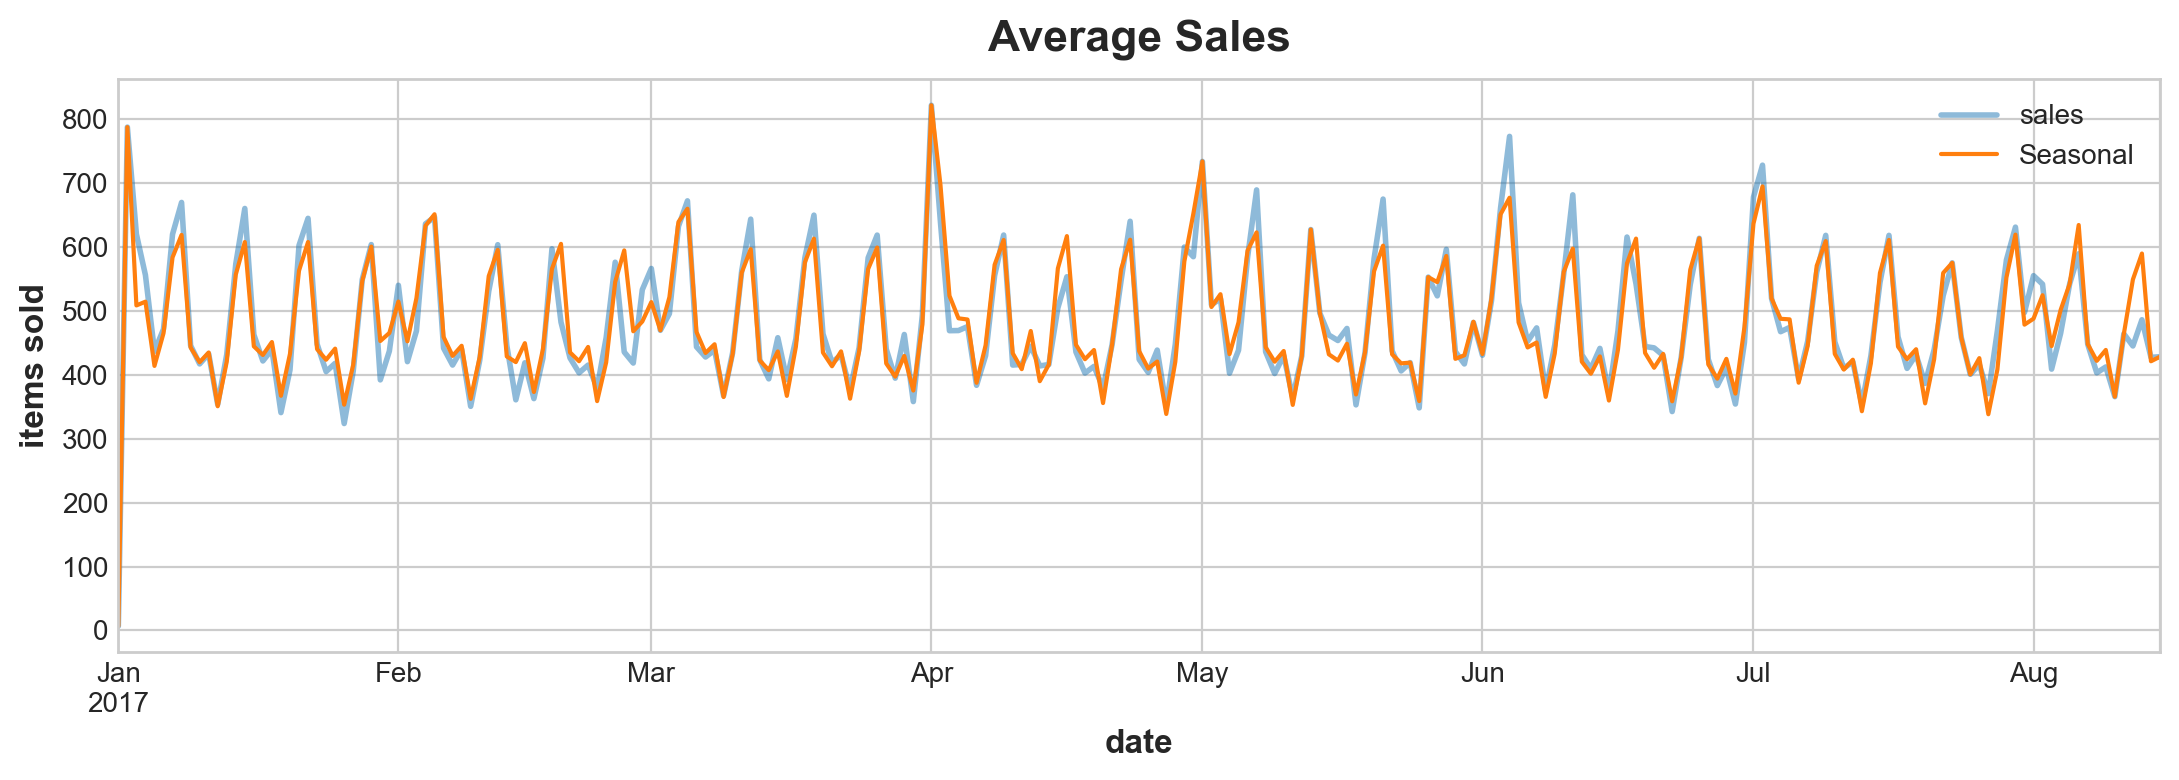

In [17]:
model.fit(X2,y)

y_pred = pd.Series(model.predict(X2), index = X2.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend()